In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpv
import seaborn as sns
from sklearn.base import BaseEstimator,TransformerMixin
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split


In [3]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)
import warnings
warnings.filterwarnings('ignore')

In [4]:
rating=pd.read_csv("dataset/ratings.csv")
link=pd.read_csv("dataset/links.csv")
movies=pd.read_csv("dataset/movies.csv")
tags=pd.read_csv("dataset/tags.csv")
genome_scores=pd.read_csv("dataset/genome-scores.csv")
genome_tags=pd.read_csv("dataset/genome-tags.csv")

movielens_dict={v:k for k,v in link.movieId.to_dict().items()}
rating.movieId=rating.movieId.apply(movielens_dict.get)
rating.userId-=1
genome_scores.movieId=genome_scores.movieId.apply(movielens_dict.get)
genome_scores.tagId-=1
genome_tags.tagId-=1

In [5]:
rating.head()

,userId,movieId,rating,timestamp
0,0,292,5.0,1147880044
1,0,302,3.5,1147868817
2,0,303,5.0,1147868828
3,0,654,5.0,1147878820
4,0,878,3.5,1147868510


In [6]:
link.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
movies.head()
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [8]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [9]:
genome_scores.head()

,movieId,tagId,relevance
0,0,0,0.02875
1,0,1,0.02375
2,0,2,0.06250
3,0,3,0.07575
4,0,4,0.14075


In [10]:
genome_tags.head()


,tagId,tag
0,0,007
1,1,007 (series)
2,2,18th century
3,3,1920s
4,4,1930s


### Extract Movie Year from Title

In [11]:
movies["year"] = movies.title.str.extract('(\(\d{4}\))')
movies.year = movies.year.str.extract('(\d+)')
movies.year = pd.to_numeric(movies.year)
#movies.genres.str.split("|", expand=True, )


In [12]:
movies.describe()

,movieId,year
count,62423.000000,62013.000000
mean,122220.387646,1992.044700
std,63264.744844,25.364884
min,1.000000,1874.000000
25%,82146.500000,1976.000000
50%,138022.000000,2002.000000
75%,173222.000000,2012.000000
max,209171.000000,2019.000000


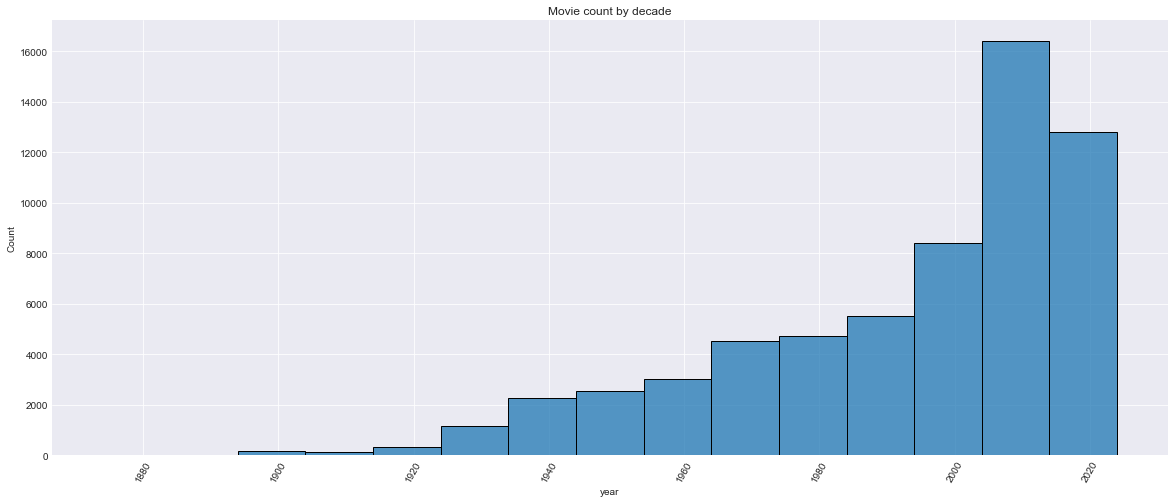

In [13]:
fig, ax = plt.subplots(figsize=(20, 8))
p1=sns.histplot(data=movies, x='year', ax=ax, binwidth=10)
plt.title('Movie count by decade')
plt.xticks(rotation=60)
plt.show()


In [14]:
genres = movies.genres.str.get_dummies().add_prefix('g_')
movies = pd.concat([movies, genres], axis=1)

In [15]:
movies.head()

,movieId,title,genres,year,g_(no genres listed),g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,...,g_Film-Noir,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
g_cols = [ col for col in movies.columns if col.startswith("g_")] 

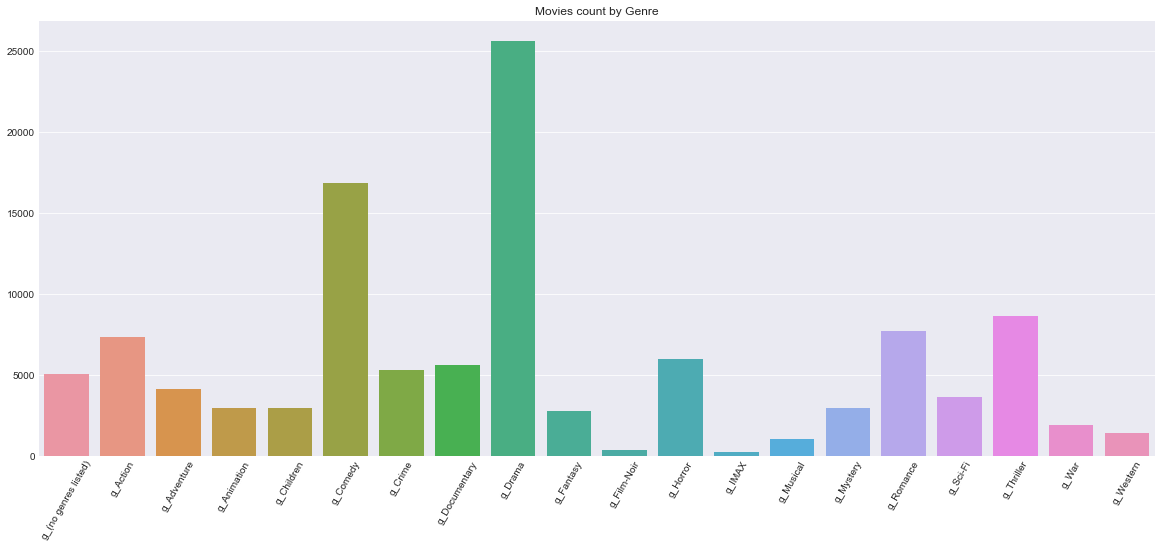

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
p1=sns.barplot(x=g_cols, y=movies[g_cols].sum(), ax=ax)
plt.title('Movies count by Genre')
plt.xticks(rotation=60)
plt.show()


In [18]:
by_decade_genres= movies[g_cols].groupby(np.floor(movies.year/10)*10).sum()
by_decade_genres = by_decade_genres.transpose()
for col in by_decade_genres.columns:
    by_decade_genres[col] = by_decade_genres[col]/by_decade_genres[col].sum()

by_decade_genres


year,1870.0,1880.0,1890.0,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
g_(no genres listed),0.5,0.285714,0.317073,0.188596,0.108262,0.069296,0.055246,0.036784,0.046450,0.053372,0.054807,0.048158,0.041693,0.031572,0.040628
g_Action,0.0,0.000000,0.016260,0.035088,0.025641,0.021322,0.024701,0.028634,0.041352,0.059923,0.087920,0.085627,0.080099,0.066805,0.064451
g_Adventure,0.0,0.000000,0.000000,0.021930,0.045584,0.041578,0.035060,0.031938,0.053059,0.061841,0.038822,0.044242,0.037444,0.033972,0.030556
g_Animation,0.0,0.000000,0.008130,0.021930,0.022792,0.030917,0.046215,0.046476,0.030967,0.015021,0.017356,0.027625,0.022049,0.025184,0.026648
g_Children,0.0,0.000000,0.008130,0.008772,0.014245,0.007463,0.012218,0.020705,0.018693,0.021253,0.024092,0.028366,0.034076,0.028154,0.027019
g_Comedy,0.0,0.000000,0.105691,0.214912,0.273504,0.176972,0.180080,0.148678,0.119147,0.148130,0.129139,0.164691,0.162284,0.148989,0.149387
g_Crime,0.0,0.000000,0.000000,0.035088,0.025641,0.024520,0.061355,0.064537,0.065521,0.056568,0.067710,0.043395,0.049792,0.045852,0.037033
g_Documentary,0.5,0.714286,0.317073,0.057018,0.011396,0.031983,0.005843,0.007489,0.006986,0.019815,0.021809,0.022756,0.029907,0.061150,0.084736
g_Drama,0.0,0.000000,0.040650,0.070175,0.247863,0.308102,0.239575,0.220044,0.246224,0.235379,0.230190,0.198984,0.234285,0.236950,0.223738
g_Fantasy,0.0,0.000000,0.105691,0.223684,0.045584,0.025586,0.011687,0.016520,0.015483,0.022691,0.020096,0.032917,0.026780,0.025510,0.023652


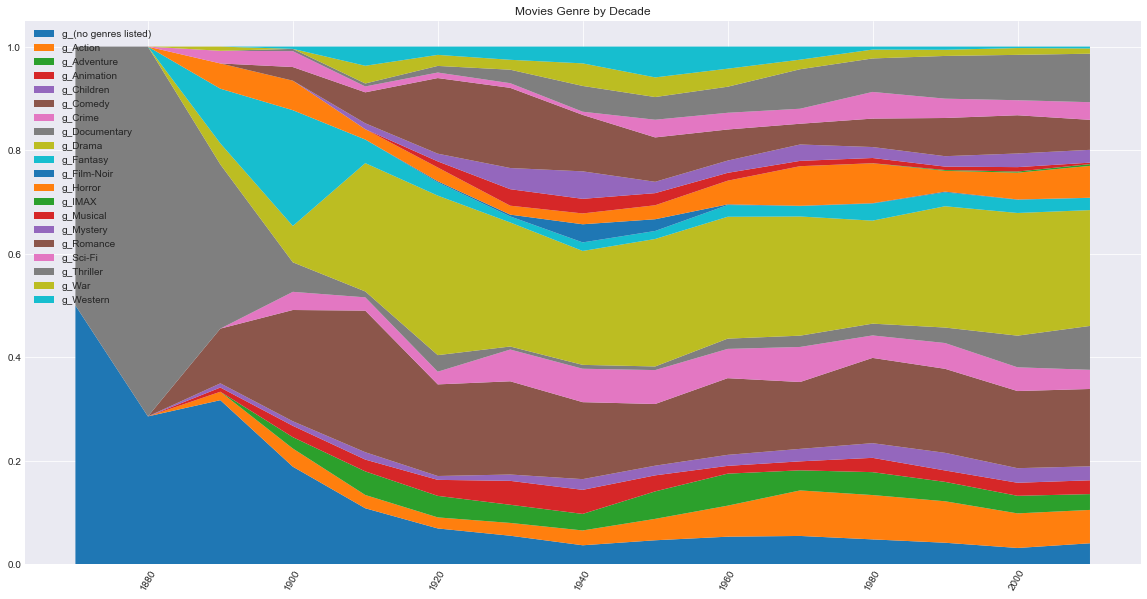

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
p1=plt.stackplot(by_decade_genres.columns, by_decade_genres, labels=by_decade_genres.index)
plt.title('Movies Genre by Decade')
plt.xticks(rotation=60)
plt.legend(loc="upper left")
plt.show()


In [20]:
# define transformers
class SparseMatrixTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,row=None,col=None,value=None,shape=None):
        self.row=row
        self.col=col
        self.value=value
        self.shape=shape
    
    def fit(self,X,y=None):
        self.shape=(X[self.row].max()+1,X[self.col].max()+1)
        return self
    
    def transform(self,X,y=None):
        if type(X) is pd.DataFrame:
            return sparse.csr_matrix(sparse.coo_matrix((X[self.value],(X[self.row],X[self.col])),self.shape))
        else:
            return sparse.csr_matrix(sparse.coo_matrix((X[:,2],(X[:,0],X[:,1])),self.shape))
    
user_movie_transformer=SparseMatrixTransformer(row="userId",col="movieId",value="rating").fit(rating)
movie_tag_transformer=SparseMatrixTransformer(row="movieId",col="tagId",value="relevance",shape=(user_movie_transformer.shape[1],genome_tags.tagId.max()+1))

In [21]:
# base class for recommendation system
class RecommenderMixin(BaseEstimator,TransformerMixin):
    def __init__(self,n_rec=10):
        self.n_rec=n_rec
    
    def evaluate(self,X_train,X_valid,silent=False):
        n_users,n_items=X_train.shape
        X=(X_train+X_valid).T
        item_rating=np.array([row.data.mean() if row.nnz else 0 for row in X])
        item_rating[np.isnan(item_rating)]
        mean_rating=X.data.mean()
        if not silent:print("predicting...")
        recommend=self.predict(X_train)
        if not silent:print("evaluating...")
        intersect=np.asarray(X_valid[np.arange(n_users).repeat(self.n_rec),recommend.flatten()].reshape(n_users,-1))
        hit=(intersect!=0).sum()
        precision=hit/recommend.size
        recall=hit/X_valid.nnz
        coverage=np.unique(recommend).size/n_items
        hit_rating=(intersect[intersect!=0]).mean()
        indices=recommend[(intersect!=0)]
        recom_rating=np.average(item_rating[indices])
        print("accuracy=%.4f"%precision)
        print("recall=%.4f"%recall)
        print("cover=%.4f"%coverage)
        print("user's vote to the hit movies=%.4f"%(hit_rating))
        print("average vote to the hit movies=%.4f"%(recom_rating))
        print("average vote to all movies=%.4f"%(mean_rating))
        
    def fit_predict(self,X,y=None):
        return self.fit(X,y).predict(X)

In [22]:
# item based colaborative filtering
# calculating the similarity between movies based on users' vote to the movies
class ItemBasedCF(RecommenderMixin):
    def __init__(self,n_rec=10,n_sim=20,file_name=None,baseline=3.0):
        super().__init__(n_rec=n_rec)
        self.baseline=baseline
        if file_name:
            self.similar_matrix=sparse.load_npz(file_name)
            self.n_sim=self.similar_matrix.shape[1]
        else:
            self.n_sim=n_sim
            self.similar_matrix=None
        
    def save(self,file_name):
        sparse.save_npz(file_name,self.similar_matrix)

    def fit(self,X,y=None,silent=False):
        if not silent:print("calculating the similar matrix...")
        n_users,n_items=X.shape
        user_movie=X.copy()
        user_movie.data-=self.baseline
        norms=sparse.linalg.norm(user_movie,axis=0)
        norms[norms==0]=1
        user_movie*=sparse.diags(1/norms)
        movie_sim_matrix=user_movie.T*user_movie
        if not silent:print("sparsifying similar matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in movie_sim_matrix]).flatten()
        self.similar_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(movie_sim_matrix[row,col]).flatten(),(row,col)),(n_items,n_items)))
        if not silent:print("fitting done.")
        return self
    
    def transform(self,X,y=None):
        user_movie=X.copy()
        user_movie.data-=self.baseline
        return user_movie*self.similar_matrix
    
    def predict(self,X):
        watched_movies=X.copy()
        watched_movies.data.fill(np.inf)
        movie_favor=self.transform(X)-watched_movies
        return np.array([np.argpartition(row.toarray().flatten(),-self.n_rec)[-self.n_rec:].copy() for row in movie_favor])
    
# itemCF=ItemBasedCF(file_name="ItemBasedCF.npz")

In [23]:
# content based recommendation system
# calculating the similarity between movies based their relevance to each tags
class ContentBasedRS(RecommenderMixin):
    def __init__(self,n_rec=10,n_sim=100,file_name=None,baseline=3.0):
        super().__init__(n_rec=n_rec)
        self.baseline=baseline
        if file_name:
            self.similar_matrix=sparse.load_npz(file_name)
            self.n_sim=self.similar_matrix.shape[1]
        else:
            self.n_sim=n_sim
            self.similar_matrix=None
        
    def save(self,file_name):
        sparse.save_npz(file_name,self.similar_matrix)

    def fit(self,X,y=None,silent=False):
        n_items,n_features=X.shape
        if not silent:print("sparsifying relevance matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in X]).flatten()
        relevance_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(X[row,col]).flatten(),(row,col)),(n_items,n_features)))
        if not silent:print("calculating the similar matrix...")
        movie_sim_matrix=relevance_matrix*relevance_matrix.T
        if not silent:print("sparsifying similar matrix...")
        row=np.arange(n_items).repeat(self.n_sim)
        col=np.array([np.argpartition(row.toarray().flatten(),-self.n_sim)[-self.n_sim:].copy() for row in movie_sim_matrix]).flatten()
        self.similar_matrix=sparse.csr_matrix(sparse.coo_matrix((np.asarray(movie_sim_matrix[row,col]).flatten(),(row,col)),(n_items,n_items)))
        if not silent:print("fitting done.")
        return self
    
    def transform(self,X,y=None):
        user_movie=X.copy()
        user_movie.data-=self.baseline
        return user_movie*self.similar_matrix
    
    def predict(self,X):
        watched_movies=X.copy()
        watched_movies.data.fill(np.inf)
        movie_favor=self.transform(X)-watched_movies
        return np.array([np.argpartition(row.toarray().flatten(),-self.n_rec)[-self.n_rec:].copy() for row in movie_favor])
    
# contentRS=ContentBasedCF(file_name="ContentBasedRS.npz")

In [24]:
# fitting content based recommendation system
contentRS=ContentBasedRS()
%time contentRS.fit(movie_tag_transformer.transform(genome_scores))
#if saving:contentRS.save("ContentBasedRS.npz")

sparsifying relevance matrix...
calculating the similar matrix...
sparsifying similar matrix...
fitting done.
Wall time: 7min 46s


ContentBasedRS()

In [25]:
# fitting item based colaborative filtering
itemCF=ItemBasedCF()
%time itemCF.fit(user_movie_transformer.transform(rating))
# if saving:itemCF.save("ItemBasedCF.npz")

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
Wall time: 1min 40s


ItemBasedCF()

In [27]:
def movie_similar(rs, movie):
    index = rs.similar_matrix[movie].indices
    return pd.merge(movies.iloc[index].reset_index(drop=True), pd.DataFrame({"similar": rs.similar_matrix[movie, index].toarray().flatten()}), left_index=True, right_index=True).sort_values("similar", ascending=False).reset_index(drop=True)


movie_similar(itemCF, 17506)


,movieId,title,genres,year,g_(no genres listed),g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,...,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,similar
0,91658,"Girl with the Dragon Tattoo, The (2011)",Drama|Thriller,2011.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.000000
1,67255,"Girl with the Dragon Tattoo, The (Män som hata...",Crime|Drama|Mystery|Thriller,2009.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0.388818
2,112556,Gone Girl (2014),Drama|Thriller,2014.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.306625
3,99114,Django Unchained (2012),Action|Drama|Western,2012.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.276159
4,74458,Shutter Island (2010),Drama|Mystery|Thriller,2010.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0.267565
5,68157,Inglourious Basterds (2009),Action|Drama|War,2009.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.266654
6,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,2010.0,0,1,0,0,0,0,...,0,1,0,1,0,1,1,0,0,0.265561
7,96079,Skyfall (2012),Action|Adventure|Thriller|IMAX,2012.0,0,1,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0.260122
8,91529,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX,2012.0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0.259667
9,97304,Argo (2012),Drama|Thriller,2012.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.257118


In [30]:
def user_recommend(rs, user):
    return movies.iloc[rs.predict(user_movie_transformer.transform(rating)[[user]]).flatten()].reset_index(drop=True)


user_recommend(itemCF, 5)


,movieId,title,genres,year,g_(no genres listed),g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,...,g_Film-Noir,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western
0,541,Blade Runner (1982),Action|Sci-Fi|Thriller,1982.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,1992.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery,1999.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1983.0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2959,Fight Club (1999),Action|Crime|Drama|Thriller,1999.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1221,"Godfather: Part II, The (1974)",Crime|Drama,1974.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
7,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
8,1193,One Flew Over the Cuckoo's Nest (1975),Drama,1975.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [31]:
def user_watched(user):
    watched_movies = rating[rating.userId == user]
    return pd.DataFrame({"title": movies.title.iloc[watched_movies.movieId], "genres": movies.genres.iloc[watched_movies.movieId], "rating": watched_movies.rating.values})


user_watched(5)


,title,genres,rating
159,Crimson Tide (1995),Drama|Thriller|War,2.0
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,5.0
314,"Shawshank Redemption, The (1994)",Crime|Drama,5.0
522,Schindler's List (1993),Drama|War,5.0
585,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.0
600,Fargo (1996),Comedy|Crime|Drama|Thriller,5.0
840,"Godfather, The (1972)",Crime|Drama,5.0
881,Breakfast at Tiffany's (1961),Drama|Romance,4.0
891,Casablanca (1942),Drama|Romance,4.0
892,"Maltese Falcon, The (1941)",Film-Noir|Mystery,4.0


In [34]:
# evaluating and comparing the recommendation system
rating_train,rating_valid=train_test_split(rating[["userId","movieId","rating"]])
rating_train=user_movie_transformer.transform(rating_train)
rating_valid=user_movie_transformer.transform(rating_valid)
%time ItemBasedCF().fit(rating_train).evaluate(rating_train,rating_valid)
%time ContentBasedRS().fit(movie_tag_transformer.transform(genome_scores)).evaluate(rating_train,rating_valid)

calculating the similar matrix...
sparsifying similar matrix...
fitting done.
predicting...
evaluating...
accuracy=0.2897
recall=0.0754
cover=0.1241
user's vote to the hit movies=4.3186
average vote to the hit movies=4.0349
average vote to all movies=3.5339
Wall time: 1min 46s


NameError: name 'movielens_score' is not defined

In [46]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader



In [49]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

In [50]:
svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0


In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
svd.predict(uid=10, iid=100)